# Clustering with K-means and DBSCAN

In this project I am going explore two clustering methods:

  - K-Means, and
  - DBSCAN
  
K-means creates clusters based on a distance measure, and DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, I will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, I will write my helper functions to not assume a 2-D data set. My plotting code will reference the `x` and `y` column names from the sample data directly. 

Below is the importation of libraries for visualization and computations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Part 1 : K-Means

In [2]:
df_kmeans = pd.read_csv('data_kmeans.csv')

## Writing a function that returns `k` random rows from a data frame

To initialize the centroids, I will pick `k` random points from a data frame.  I am going to write a function `init_centroids( df_data, k )` that accepts two parameters: a data frame `df_data`, and an integer `k`, and returns the initial centroids for my k-means algorithm.  Note, I want the indices of the returned data frame to range from 0 - (k-1) so that I can use these as the centroid labels. I passed in the value of $42$ for `random_state`. 

In [3]:
def init_centroids( df_data, k ):

    centroids = df_data.sample(n=k, random_state=42).reset_index(drop=True)
    return centroids  


In [4]:
# Testing my init centroid function

df_centroids = init_centroids( df_kmeans, 7 )
df_centroids


,x,y
0,-0.633437,0.488756
1,-0.597736,0.632194
2,-0.635867,0.166613
3,-0.539351,-0.875532
4,-0.588597,0.293062
5,-0.127985,-0.136639
6,0.342579,0.211717


## Writing a function to assign every row in a data frame to a centroid 

I am going to write a function, `assign_to_centroid`, that accepts two parameters: a data frame, `df_data`, that represents the data to be clustered, and the data frame, `df_centroids`, which is of length `k` and contains the current centroids for the clusters.  The functions returns a series of the same length of `df_data` that contains the index of the closest centroid in `df_centroid`.  I am going to use Euclidean distance as my distance measure. 

For example, if a row of data contained the data point $(100,123)$ and the three centroids were in a data frame that had the following information:

  - Index 0 : (34,34)
  - Index 1 : (0,1)
  - Index 2 : (83,99)

The `assign_to_centroid` function would assign the index $2$ to that row of data. 

In [5]:
def assign_to_centroid( df_data, df_centroids ):
    
    assigned_centroids = pd.Series([], dtype='int')
    
    for index, sample in df_data.iterrows():
        assigned_centroid = np.argmin([np.linalg.norm(np.array(sample)-np.array(centroid)) for (index, centroid) in df_centroids.iterrows()])
        assigned_centroids.at[index] = assigned_centroid
        
    return assigned_centroids

In [6]:
# Checking how many data points were assigned to each centroid

s_centroid_assignment = assign_to_centroid( df_kmeans, df_centroids )
s_centroid_assignment.value_counts()


6    126
1     94
3     71
5     58
0     53
2     26
4     22
dtype: int64

## Writing a function that recomputes the centroids

I am going to write a function `compute_centroids` that takes two parameters: the data frame, `df_data` containing the data being clustered, and a series of the same length that contains the label of the assigned centroid for every row in df_data, `s_centroid_assignment`. The function will return the a data frame containing the centroids (mean) value for each unique centroid. 

Note that the indices in the returned data frame will correspond to the unique values in `s_centroid_assignment`.  For example, if I found the mean value of df_data using the slice corresponding to `s_centroid_assigment == 2`, then the centroid should be in the returned data frame at `.iloc[2]`. 


In [7]:
def compute_centroids( df_data, s_centroid_assignment ):
    
    df_new_centroids = pd.DataFrame()
    
    for index in sorted(s_centroid_assignment.unique()):
        
        current_assignment_keys = s_centroid_assignment[s_centroid_assignment == index].keys()
        related_samples = df_data.iloc[current_assignment_keys]
        df_new_centroids = df_new_centroids.append(related_samples.mean(), ignore_index=True)
        
    return df_new_centroids


In [8]:
# Testing it out

df_new_centroids = compute_centroids( df_kmeans, s_centroid_assignment)
df_new_centroids


,x,y
0,-0.715983,0.500552
1,-0.721574,0.708343
2,-0.738268,-0.113830
3,-0.696694,-0.699028
4,-0.546913,0.321364
5,-0.102365,-0.188876
6,0.523364,0.238569


## Writing a function that compares two centroid data frames

The stopping criterion for k-means is when my centroids have not moved since the last iteration.  I am going to write a function `compare_centroids` that is given 2 centroid data frames, `df_centroid_a`, and `df_centroid_b` as parameters and returns `True` or `False` indicating if the centroids at each unique index in the data frame are equal. 

In [9]:
def compare_centroids( df_centroid_a, df_centroid_b ):

    return df_centroid_a.equals(df_centroid_b)


In [10]:
# Testing it out, should print True followed by False

print(compare_centroids( df_new_centroids, df_new_centroids ))
print(compare_centroids( df_new_centroids, df_centroids ))


True
False


## Writing a function that implements k-means

I am going to write a function, `k_means`, that takes in as parameters 2 values, a data frame with values to cluster, `df_data`, and the number of clusters to form, `k`.  The function should return a series of data of the same length as `df_data` that contains the cluster assignment (an integer from 0 to (k-1)) for each row of data. I will use the helper functions defined in the prior sections. 

In [11]:
def k_means( df_data, k ):
    
    centroids = init_centroids(df_data, k)
    centroid_assignment = assign_to_centroid(df_data, centroids)
    new_centroids = compute_centroids(df_data, centroid_assignment)
    
    while(not compare_centroids(centroids, new_centroids)):
        centroid_assignment = assign_to_centroid(df_data, new_centroids)
        centroids = new_centroids.copy(deep=True)
        new_centroids = compute_centroids(df_data, centroid_assignment)
        
    return centroid_assignment

In [12]:
# Calling k_means with k = 5 to test

s_cluster_assignment = k_means( df_kmeans, 5)
s_cluster_assignment.value_counts()


0    178
3     89
2     74
4     63
1     46
dtype: int64

## Plotting the results

I will plot the points in the `df_kmeans` data frame using a 2-D scatter plot, with a different color for each cluster.  I will use the cluster assignments from the previous problem (`s_cluster_assignments`). 

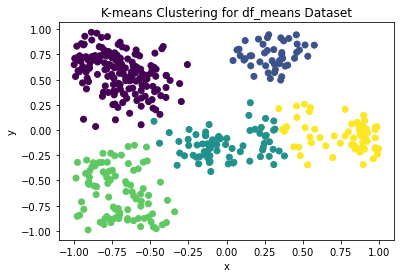

In [13]:
# Plotting each cluster

plt.scatter(df_kmeans.x, df_kmeans.y, c=s_cluster_assignment)
plt.title('K-means Clustering for df_means Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# Part 2 : DBSCAN

## Loading the Density Data and try K-means

I will load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. 

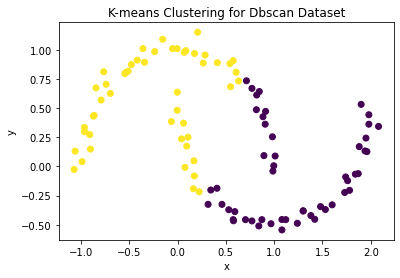

In [14]:
df_dbscan = pd.read_csv('data_dbscan.csv')

# Calling k_means with k = 2
s_cluster_assignment = k_means( df_dbscan, 2)


plt.scatter(df_dbscan.x, df_dbscan.y, c=s_cluster_assignment)
plt.title('K-means Clustering for Dbscan Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Writing a function to Implement Range Query

I used the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia to implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in my data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice will be preserved (I will not reset_index).  

In [15]:
def range_query( df_data, q_index, eps ):
    
    neighbors = pd.DataFrame()
    
    for index, entry in df_data.iterrows():
        if(np.linalg.norm(np.array(entry)-np.array(df_data.iloc[q_index])) <= eps):
            neighbors = neighbors.append(entry)
            
    return neighbors

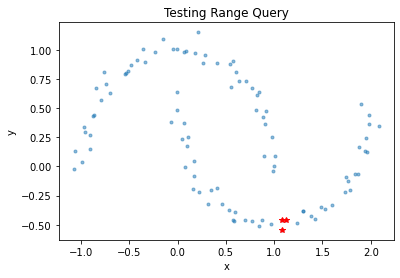

In [16]:
# Testing it out
df_n = range_query( df_dbscan, 0, 0.1 )
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Writing a function to implement DBSCAN

I used the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia to implement DBSCAN. 
```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

My function will accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`. My function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

I will call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments`. 

In [17]:
def dbscan( df_data, eps, min_pts ):
    NOISE_LABEL = 0
    
    c = 0
    labels = [None]*len(df_data)
    
    for index, point in df_data.iterrows():
        if labels[index] is not None:
            continue
            
        neighbors = range_query(df_data, index, eps)
        if len(neighbors) < min_pts:
            labels[index] = NOISE_LABEL
            continue
            
        c = c + 1
        labels[index] = c
        seed_set = neighbors.drop(index).astype('float64')
        seed_set_list = seed_set.values.tolist()
        i = 0
        
        while(i < len(seed_set_list)):
            current_index = seed_set.iloc[i].name
            if labels[current_index] == NOISE_LABEL:
                labels[current_index] = c
            if labels[current_index] is not None:
                i += 1
                continue
                
            labels[current_index] = c
            inner_neighbors = range_query(df_data, current_index, eps)
            if len(inner_neighbors) >= min_pts:
                seed_set = seed_set.append(inner_neighbors)
                seed_set = seed_set[~seed_set.index.duplicated(keep='first')]
                current_seed_set_list = seed_set.values.tolist()
                seed_set_list.extend([x, y] for (x, y) in current_seed_set_list if [x, y] not in seed_set_list)
            i += 1
            
    return pd.Series(labels)


In [18]:
# Testing it out

s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts()


1    49
2    48
0     3
dtype: int64

## Plotting the Results 

I will plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  I will use the cluster assignments from the previous section (`s_cluster_assignments`).

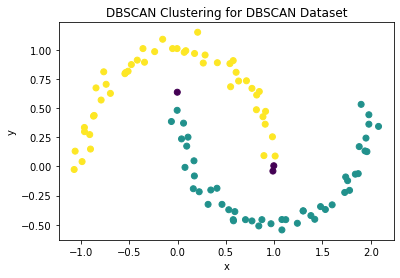

In [19]:
# Plotting each cluster

plt.scatter(df_dbscan.x, df_dbscan.y, c=s_cluster_assignment)
plt.title('DBSCAN Clustering for DBSCAN Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


## Comparing my results to the scikit-learn library

I will import DBSCAN from scikit-learn and compare the cluster labels from my implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). I will use the same data and values for eps and minPts.

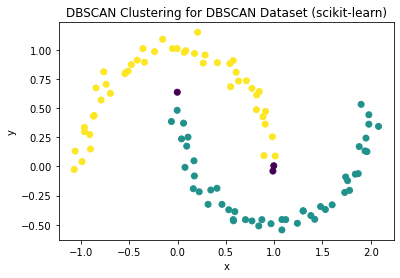

In [20]:
# checking my implementation vs scikit-learn

from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.23, min_samples=6).fit(df_dbscan)
labels = clustering.labels_
plt.scatter(df_dbscan.x, df_dbscan.y, c=labels)
plt.title('DBSCAN Clustering for DBSCAN Dataset (scikit-learn)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


The scikit-learn's algorithm and my implementation gave the same results so the performance is similar.